In [12]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import acoular as ac
import matplotlib.animation as anim


In [ ]:

dataName = '2025-01-28_15-18-43_492418'

resFolderName = 'out/beamforming_results_25_02_16/'+dataName

cameraPosition = 1
dotsize = 4
currentFrequencyBand = 0

# Open and read the JSON file
with open(resFolderName + '/evaluation_config.json', 'r') as file:
    config_data = json.load(file)

# Access the output folder path
out_folder = config_data['out_folder']
print(f"Output Folder: {out_folder}")

# read Data
result = np.load(resFolderName+ '/result_'+dataName + ".npy")
map = result
resolution = config_data['calc_grid_res_meters']
frequencyBands = config_data['frequency_bands']
frameRate = config_data['frame_rate_fps']

Output Folder: ./evaluation/out/


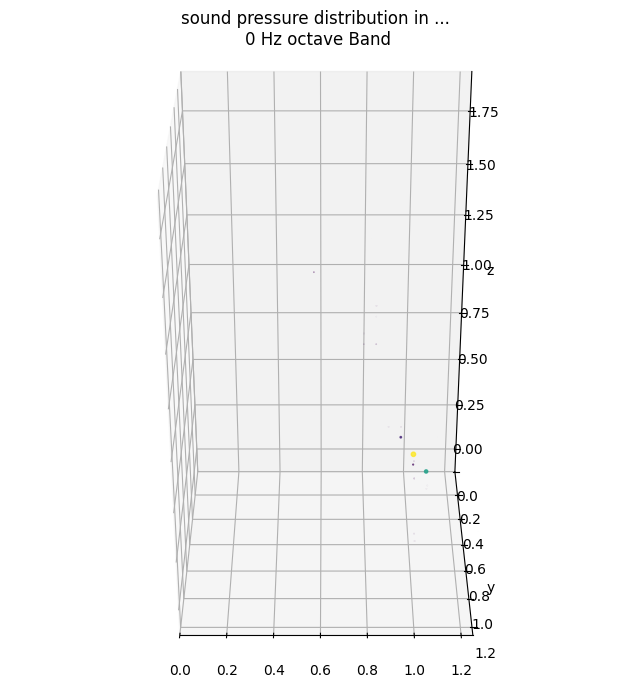

NameError: name 'cameraPosition' is not defined

In [13]:
fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')

ax.view_init(elev=30, 
             azim=270, 
             roll=0)
ax.set_proj_type('persp', focal_length=0.547)

x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[2]*resolution,map.shape[2]),
                            np.linspace(0,map.shape[3]*resolution,map.shape[3]), 
                            np.linspace(0,map.shape[4]*resolution,map.shape[4]))

scat = ax.scatter(x_m, y_m, z_m, c = map[1,1], s = map[1,1]*10**dotsize, alpha = 0.8)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(0, map.shape[2]*resolution)
ax.set_ylim(map.shape[3]*resolution, 0)
ax.set_title('sound pressure distribution in ... \n'+str(currentFrequencyBand)+' Hz octave Band')
ax.set_aspect('equal')


def update(frame):
    color = map[currentFrequencyBand,frame,:,:,:]
    size = map[currentFrequencyBand,frame,:,:,:]*10**dotsize
    alpha = map[currentFrequencyBand,frame,:,:,:]
    scat.set_alpha(alpha)
    scat.set_color(color)
    scat.set_sizes(size)

    return (scat)


ani = anim.FuncAnimation(fig=fig, func=update, frames=map.shape[1], interval=(1/25)*1000)
plt.show()

resFileName = '/out/video_data/'+dataName+'camera_'+cameraPosition+'.mp4'
# ani.save(filename=resFileName, writer="ffmpeg")